In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
import scipy.io as sio
import scipy.stats as spstat
import scipy.sparse.linalg as spsplin
import scipy.sparse as spsp
import time

import sys
sys.path.insert(0, '../src/')

import sai

In [2]:
# Discretization 200x200 with homogeneous boundary conditions
data = sio.loadmat("../data/pe1000nons_202x202.mat")
# Discretization 300x300 with homogeneous boundary conditions
# data = sio.loadmat("../data/pe1000nons_302x302.mat")

A = data["A"]
u0 = data["v"]
n = int(np.sqrt(A.shape[0]))

In [3]:
start = 0.
stop = 0.0001
delta_trial = 0.1

In [4]:
if n == 200:
    u_test_data = np.load("../data/u_test_200.npz")
elif n == 300:
    u_test_data = np.load("../data/u_test_300.npz")
U = u_test_data["U_test"]
batch_size = U.shape[1]
print(U.shape)

(40000, 20)


In [5]:
u0.shape

(40000, 1)

In [6]:
ut, der = sai.expm_ArnoldiSAI2_der(A, u0.ravel(), stop, delta_trial*stop, 1e-5, 1000)

Computing sparse LU factorization of the SAI matrix...
j = 0, resnorm = 9978.539098572664
j = 1, resnorm = 44929.40735511692
j = 2, resnorm = 21493.661474343236
j = 3, resnorm = 18895.836670549143
j = 4, resnorm = 16682.92633205598
j = 5, resnorm = 11943.229523391628
j = 6, resnorm = 3810.2537157977877
j = 7, resnorm = 6468.649597116109
j = 8, resnorm = 5185.785217387113
j = 9, resnorm = 4562.999373751641
j = 10, resnorm = 4404.599982585617
j = 11, resnorm = 4438.242964724067
j = 12, resnorm = 2884.5793458856438
j = 13, resnorm = 4319.890276642607
j = 14, resnorm = 1244.4027875704044
j = 15, resnorm = 3036.1491275356175
j = 16, resnorm = 2901.868249894442
j = 17, resnorm = 637.4712850385139
j = 18, resnorm = 3087.919150312675
j = 19, resnorm = 3343.642144613083
j = 20, resnorm = 1155.1176472500601
j = 21, resnorm = 2982.8575834779444
j = 22, resnorm = 4402.486722609882
j = 23, resnorm = 2698.8499884824123
j = 24, resnorm = 1554.7599709393705
j = 25, resnorm = 4105.908805409523
j = 26, 

In [7]:
print("Derivative estimate =", der)

Derivative estimate = 92.78544337765574


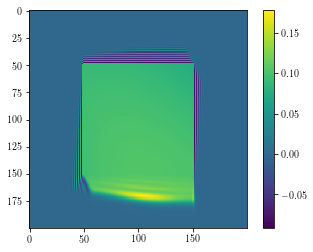

In [8]:
plt.imshow(ut.reshape(n, n))
plt.colorbar()

## Improve $\gamma$ for every next initial vector

In [9]:
gamma0 = delta_trial * stop
tol = 1e-6
max_iter = 1000

In [10]:
conv_hist_base = []
st_lu = time.time()
A_lu = spsplin.splu(spsp.eye(A.shape[0], format="csc") + gamma0 * A)
fin_lu = time.time()
time_conv_gamma0 = [fin_lu - st_lu]
for i in range(batch_size):
    print("Index of the processing vector =", i)
    u0 = U[:, i][:, np.newaxis]
    st = time.time()
    _, _, conv_base = sai.expm_ArnoldiSAI(A, u0, stop, gamma0, tol, max_iter, disp=False, A_lu=A_lu)
    time_conv_gamma0.append(time_conv_gamma0[-1] - st + time.time())
    conv_hist_base.append(len(conv_base[conv_base > 0]))

Index of the processing vector = 0
Index of the processing vector = 1
Index of the processing vector = 2
Index of the processing vector = 3
Index of the processing vector = 4
Index of the processing vector = 5
Index of the processing vector = 6
Index of the processing vector = 7
Index of the processing vector = 8
Index of the processing vector = 9
Index of the processing vector = 10
Index of the processing vector = 11
Index of the processing vector = 12
Index of the processing vector = 13
Index of the processing vector = 14
Index of the processing vector = 15
Index of the processing vector = 16
Index of the processing vector = 17
Index of the processing vector = 18
Index of the processing vector = 19


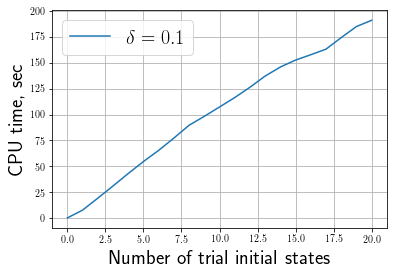

In [20]:
plt.plot(time_conv_gamma0, label=r"$\delta = {}$".format(delta_trial))
plt.grid(True)
plt.xlabel("Number of trial initial states", fontsize=20)
plt.ylabel("CPU time, sec", fontsize=20)
plt.legend(fontsize=20)

In [21]:
time_conv_opt = [0.0]
active_delta = []
low_delta = 0.01
up_delta = 0.1
A_lu = None
conv_hist = []
for i in range(batch_size):
    current_delta = (low_delta + up_delta) * 0.5
    print("Test vector index = {}, current delta = {}".format(i, current_delta))
    active_delta.append(current_delta)
    if np.abs(up_delta - low_delta) > 1e-5:
        st = time.time()
        ut, der = sai.expm_ArnoldiSAI2_der(A, U[:, i], stop, current_delta * stop, tol, max_iter, disp=False)
        time_conv_opt.append(time_conv_opt[-1] - st + time.time())
        print("Derivative estimate =", der)
        if der > 0:
            up_delta = current_delta
        else:
            low_delta = current_delta
    else:
        if A_lu is None:
            A_lu = spsplin.splu(spsp.eye(A.shape[0], format="csc") + current_delta * stop * A)
        st = time.time()
        _, _, conv_iter = sai.expm_ArnoldiSAI(A, U[:, i][:, np.newaxis], stop, current_delta * stop, tol, max_iter, False, A_lu)
        time_conv_opt.append(time_conv_opt[-1] - st + time.time())
        conv_hist.append(len(conv_iter[conv_iter > 0]))
        print(np.mean(np.array(conv_hist)))

Test vector index = 0, current delta = 0.055
Derivative estimate = 38.06597914757086
Test vector index = 1, current delta = 0.0325
Derivative estimate = 15.23587916887053
Test vector index = 2, current delta = 0.02125
Derivative estimate = 9.250084607532855
Test vector index = 3, current delta = 0.015625
Derivative estimate = 7.320208335117531
Test vector index = 4, current delta = 0.012812500000000001
Derivative estimate = 2.940356689930473
Test vector index = 5, current delta = 0.01140625
Derivative estimate = 4.190020327507534
Test vector index = 6, current delta = 0.010703125
Derivative estimate = 4.204906070891761
Test vector index = 7, current delta = 0.010351562500000001
Derivative estimate = -2.3322485797529278
Test vector index = 8, current delta = 0.010527343750000001
Derivative estimate = 1.0435107317247176
Test vector index = 9, current delta = 0.010439453125000001
Derivative estimate = 2.4206585455700647
Test vector index = 10, current delta = 0.010395507812500001
Derivati

Text(0, 0.5, 'CPU time, sec')

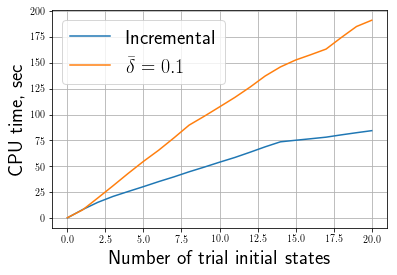

In [25]:
plt.plot(time_conv_opt, label=r"Incremental")
plt.plot(time_conv_gamma0, label=r"$\bar{\delta} = " + str(delta_trial) + "$")
plt.legend(fontsize=20)
plt.grid(True)
plt.xlabel("Number of trial initial states", fontsize=20)
plt.ylabel("CPU time, sec", fontsize=20)

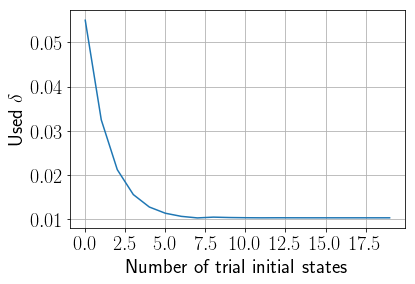

In [26]:
plt.plot(active_delta)
plt.xlabel("Number of trial initial states", fontsize=20)
plt.grid(True)
plt.ylabel("Used $\delta$", fontsize=20)
plt.yticks(fontsize=20)
_ = plt.xticks(fontsize=20)